Purpose:
    Create training sequences subset and calculate rgb mean & sd of images
    

In [ ]:
%pip install torchvision
%pip install smart_open

In [1]:
# Setup environment
import os
import glob
import time
import math
import numpy as np
from torchvision import transforms
import torch
from smart_open import smart_open

from math_functions import R_to_angle
from parameters import par
from sthree_wrapper import to_s3_npy, read_img, list_contents, test_read

In [2]:
test_read()

sequences/00/calib.txt
sequences/00/image_2/000000.png
sequences/00/image_2/000001.png
sequences/00/image_2/000002.png
sequences/00/image_2/000003.png
sequences/00/image_2/000004.png
sequences/00/image_2/000005.png
sequences/00/image_2/000006.png
sequences/00/image_2/000007.png
sequences/00/image_2/000008.png
sequences/00/image_2/000009.png
sequences/00/image_2/000010.png
sequences/00/image_2/000011.png
sequences/00/image_2/000012.png
sequences/00/image_2/000013.png
sequences/00/image_2/000014.png
sequences/00/image_2/000015.png
sequences/00/image_2/000016.png
sequences/00/image_2/000017.png
sequences/00/image_2/000018.png
sequences/00/image_2/000019.png
sequences/00/image_2/000020.png
sequences/00/image_2/000021.png
sequences/00/image_2/000022.png
sequences/00/image_2/000023.png
sequences/00/image_2/000024.png
sequences/00/image_2/000025.png
sequences/00/image_2/000026.png
sequences/00/image_2/000027.png
sequences/00/image_2/000028.png
sequences/00/image_2/000029.png
sequences/00/imag

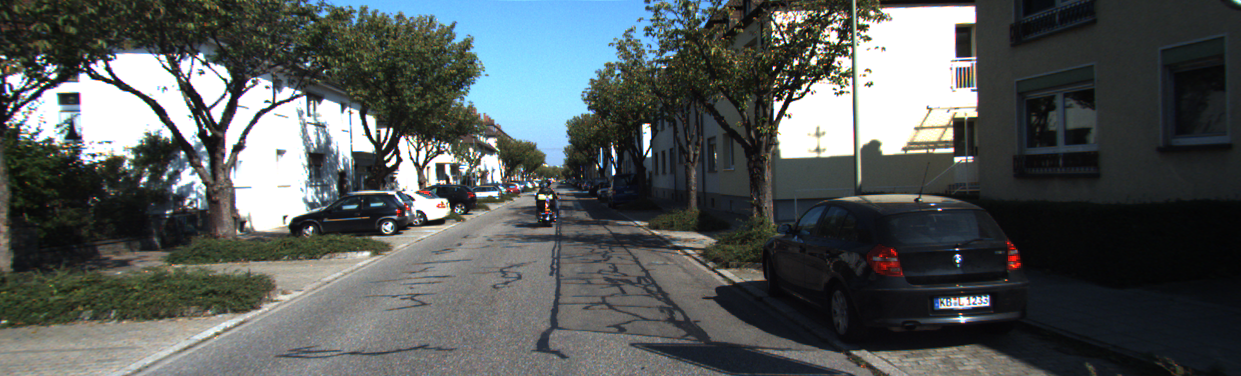

In [13]:
read_img("sequences/00/image_2/000001.png")

In [14]:
# transform poseGT [R|t] to [theta_x, theta_y, theta_z, x, y, z]
# save as .npy file
def create_pose_data():
    start_t = time.time()
    for video in par.sequences.keys():
        fn = '{}{}.txt'.format(par.pose_location, video)
        print('Transforming {}...'.format(fn))
        with smart_open(fn, "r") as f:
            lines = [line.split('\n')[0] for line in f.readlines()] 
            poses = [ R_to_angle([float(value) for value in l.split(' ')]) for l in lines]  # list of pose (pose=list of 12 floats)
            poses = np.array(poses)
            base_fn = os.path.splitext(fn)[0]
            # np.save(base_fn+'.npy', poses)
            print(base_fn+'.npy')
            to_s3_npy(poses, base_fn+'.npy')
            print('Video {}: shape={}'.format(video, poses.shape))
    print('elapsed time = {}'.format(time.time()-start_t))

In [15]:
def calculate_rgb_mean_std(image_path_list, minus_point_5=False):
    n_images = len(image_path_list)
    cnt_pixels = 0
    print('Numbers of frames in training dataset: {}'.format(n_images))
    
    # Calculate mean
    mean_np = [0, 0, 0]
    mean_tensor = [0, 0, 0]
    to_tensor = transforms.ToTensor()
    image_sequence = []
    
    # Loop through provided images
    for idx, img_path in enumerate(image_path_list):
        
        print('{} / {}'.format(idx, n_images), end='\r')
        img_as_img = read_img(img_path)
        if img_as_img != 0: # If image exists
            img_as_tensor = to_tensor(img_as_img) # Convert to tensor
            if minus_point_5: # Subtract -0.5 to center values for flownet
                img_as_tensor = img_as_tensor - 0.5
            img_as_np = np.array(img_as_img)
            img_as_np = np.rollaxis(img_as_np, 2, 0) # Move axis 2 to front? RGB->BRG
            cnt_pixels += img_as_np.shape[1]*img_as_np.shape[2] # Increment cnt_pixels by image size
            for c in range(3): # Loop through image channels
                mean_tensor[c] += float(torch.sum(img_as_tensor[c])) # Add to sums
                mean_np[c] += float(np.sum(img_as_np[c]))
        else:
            print("image " + img_path + " Not Found")
    # Divide sums by total pixels to find averages
    mean_tensor =  [v / cnt_pixels for v in mean_tensor]
    mean_np = [v / cnt_pixels for v in mean_np]
    print('mean_tensor = ', mean_tensor)
    print('mean_np = ', mean_np)
    
    # Calculate standard deviation
    std_tensor = [0, 0, 0]
    std_np = [0, 0, 0]
    for idx, img_path in enumerate(image_path_list):
        
        print('{} / {}'.format(idx, n_images), end='\r')
        img_as_img = read_img(img_path)
        if img_as_img != 0: # If image exists
            img_as_tensor = to_tensor(img_as_img) # Convert to tensor
            if minus_point_5: # Subtract -0.5 to center values for flownet
                img_as_tensor = img_as_tensor - 0.5
            img_as_np = np.array(img_as_img)
            img_as_np = np.rollaxis(img_as_np, 2, 0) # Move axis 2 to front? RGB->BRG
            for c in range(3): # Loop through image channels
                tmp = (img_as_tensor[c] - mean_tensor[c])**2 # Find mean squared deviation
                std_tensor[c] += float(torch.sum(tmp)) # Add to variance
                tmp = (img_as_np[c] - mean_np[c])**2 # Find mean squared deviation
                std_np[c] += float(np.sum(tmp)) # Add to variance
        else:
            print("image " + img_path + " Not Found")
    # Divide and take square root to find standard deviation
    std_tensor = [math.sqrt(v / cnt_pixels) for v in std_tensor]
    std_np = [math.sqrt(v / cnt_pixels) for v in std_np]
    print('std_tensor = ', std_tensor)
    print('std_np = ', std_np)
    
    modelpar.img_means = mean_tensor
    modelpar.img_stds = std_tensor

In [16]:
create_pose_data()
print("Created Pose Data")

Transforming s3://deepvo-data/poses/00.txt...
s3://deepvo-data/poses/00.npy
Video 00: shape=(4541, 15)
Transforming s3://deepvo-data/poses/01.txt...
s3://deepvo-data/poses/01.npy
Video 01: shape=(1101, 15)
Transforming s3://deepvo-data/poses/04.txt...
s3://deepvo-data/poses/04.npy
Video 04: shape=(271, 15)
elapsed time = 0.6294679641723633
Created Pose Data


In [ ]:
# Calculate RGB means of images in training videos
image_path_list = []
for folder in par.training_sequences.keys():
    for f in list_contents(par.sequence_key+folder):
        image_path_list.append(f['Key'])
calculate_rgb_mean_std(image_path_list, par.minus_point_5)

Numbers of frames in training dataset: 2544
image sequences/00/calib.txt Not Found


For sequences 00, 01, 04

mean_tensor =  [-0.1462488382606457, -0.1239967719900155, -0.1208675856721287]
mean_np =  [90.20654529530064, 95.88082224935121, 96.67876512829987]

std_tensor =  [0.2909732338687599, 0.3071966735493643, 0.3264705248159934]
std_np =  [74.19817358550188, 78.33514974320232, 83.24998064178853]